# Car_Park_Recognition
- 최종 수정일 : 2020-04-21
- 김도경

In [11]:
!pip install Pillow

In [66]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [67]:
os.getcwd()

'C:\\Python\\Source'

In [68]:
X=[]
Z=[]
IMG_SIZE=150
FREE_DIR='C:\Python\Source\input\data\data\Free'
FULL_DIR='C:\Python\Source\input\data\data\Full'

In [69]:
def assign_label(img,label):
    return label

In [70]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,label)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [71]:
# make 'Free' data
make_train_data('Free',FREE_DIR)
print(len(X))

100%|██████████████████████████████████████████████████████████████████████████████| 1067/1067 [00:51<00:00, 20.63it/s]

1067


In [87]:
# make 'Full' data
make_train_data('Full',FULL_DIR)
print(len(X))

100%|██████████████████████████████████████████████████████████████████████████████| 2195/2195 [01:41<00:00, 21.57it/s]

3262


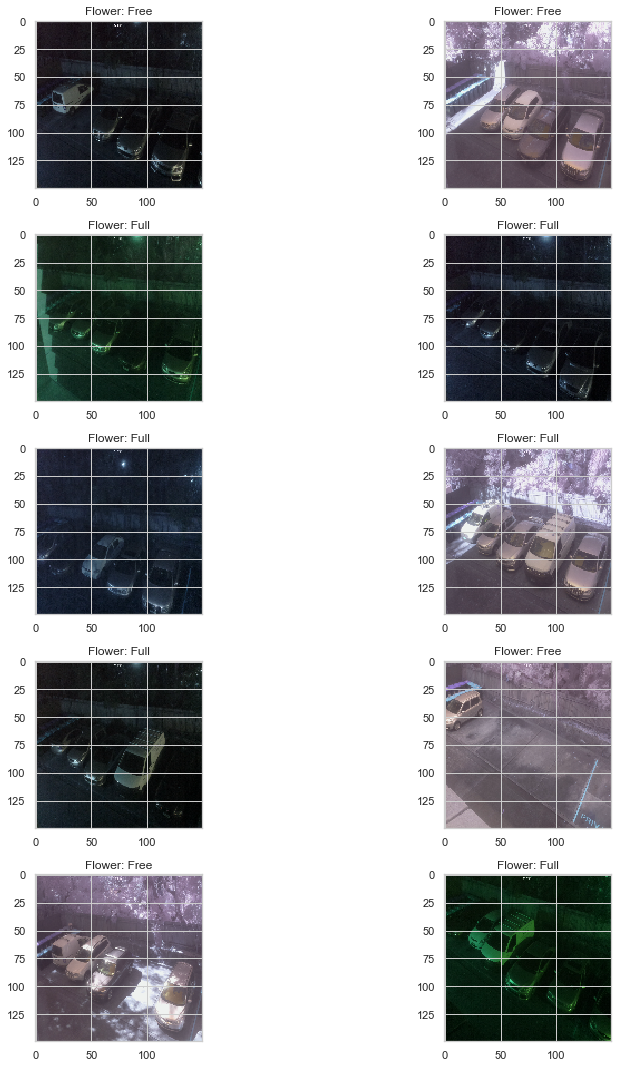

In [88]:
# check some image
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

In [89]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
X=np.array(X)
X=X/255

In [90]:
# separate data
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [91]:
# fix random seed
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [92]:

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(2, activation = "softmax"))


In [32]:
batch_size=128
epochs=50

# use callback only ReduceLROnPlateau
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [33]:
# data augmentation to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [34]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 96)       

In [36]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
19/19 [==============================] - 95s 5s/step - loss: 0.6074 - accuracy: 0.6997 - val_loss: 0.5338 - val_accuracy: 0.7377
Epoch 2/50
19/19 [==============================] - 96s 5s/step - loss: 0.5776 - accuracy: 0.7058 - val_loss: 0.5493 - val_accuracy: 0.6838
Epoch 3/50
19/19 [==============================] - 94s 5s/step - loss: 0.5233 - accuracy: 0.7494 - val_loss: 0.4966 - val_accuracy: 0.7843
Epoch 4/50
19/19 [==============================] - 95s 5s/step - loss: 0.5015 - accuracy: 0.7726 - val_loss: 0.4625 - val_accuracy: 0.8100
Epoch 5/50
19/19 [==============================] - 96s 5s/step - loss: 0.5164 - accuracy: 0.7512 - val_loss: 0.5745 - val_accuracy: 0.7022
Epoch 6/50
19/19 [==============================] - 95s 5s/step - loss: 0.4900 - accuracy: 0.7748 - val_loss: 0.4443 - val_accuracy: 0.8113
Epoch 7/50
19/19 [==============================] - 91s 5s/step - loss: 0.4736 - accuracy: 0.7913 - val_loss: 0.4878 - val_accuracy: 0.7929
Epoch 8/50
19/19 [==

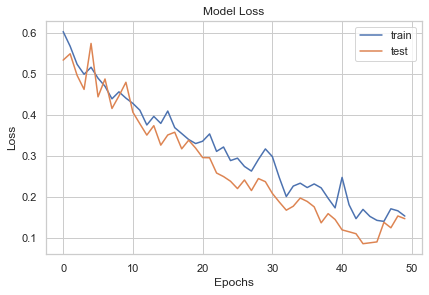

In [37]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

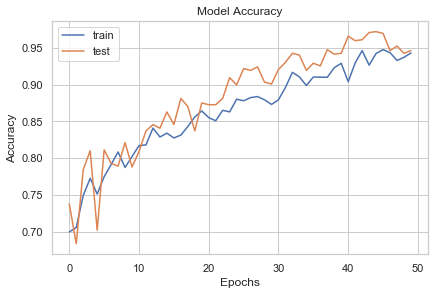

In [39]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [15]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [41]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

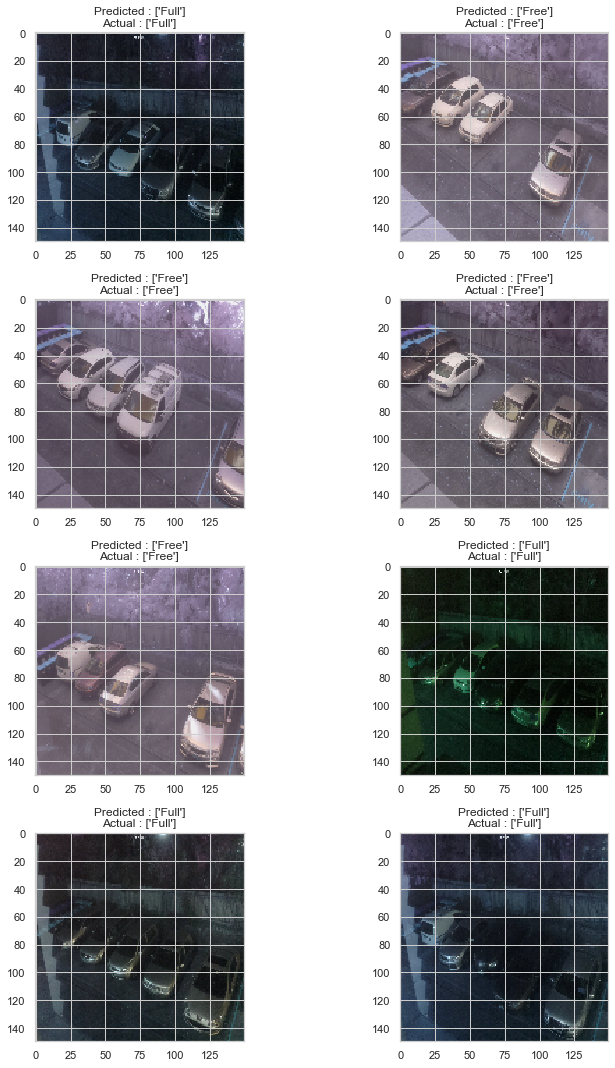

In [42]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual : "+str(le.inverse_transform([np.argmax([y_test[prop_class[count]]])])))
        plt.tight_layout()
        count+=1

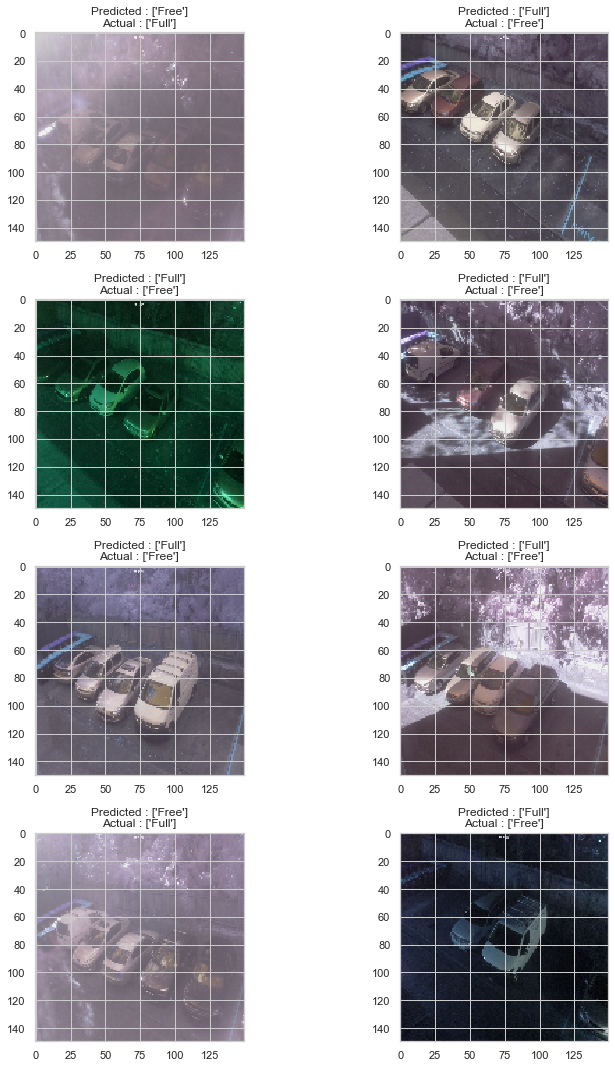

In [43]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual : "+str(le.inverse_transform([np.argmax([y_test[mis_class[count]]])])))
        plt.tight_layout()
        count+=1

In [44]:
model.save('Car_Park_Recognition_model.h5')

# 모델 불러오기

In [2]:
from keras.models import load_model
model = load_model('Car_Park_Recognition_model.h5')

# 선검출 시도

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style

In [77]:
img = cv2.imread('target1.jpg',cv2.IMREAD_COLOR)
#img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

In [78]:
image_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [79]:
image_gray.shape

(600, 500)

In [102]:
ret, binary = cv2.threshold(image_gray, 127, 255, cv2.THRESH_BINARY)
binary = cv2.bitwise_not(binary)

In [103]:
contours, hierachy = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

In [83]:
blur = cv2.GaussianBlur(image_gray, ksize=(3,3), sigmaX=0)
ret, thresh1 = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY)

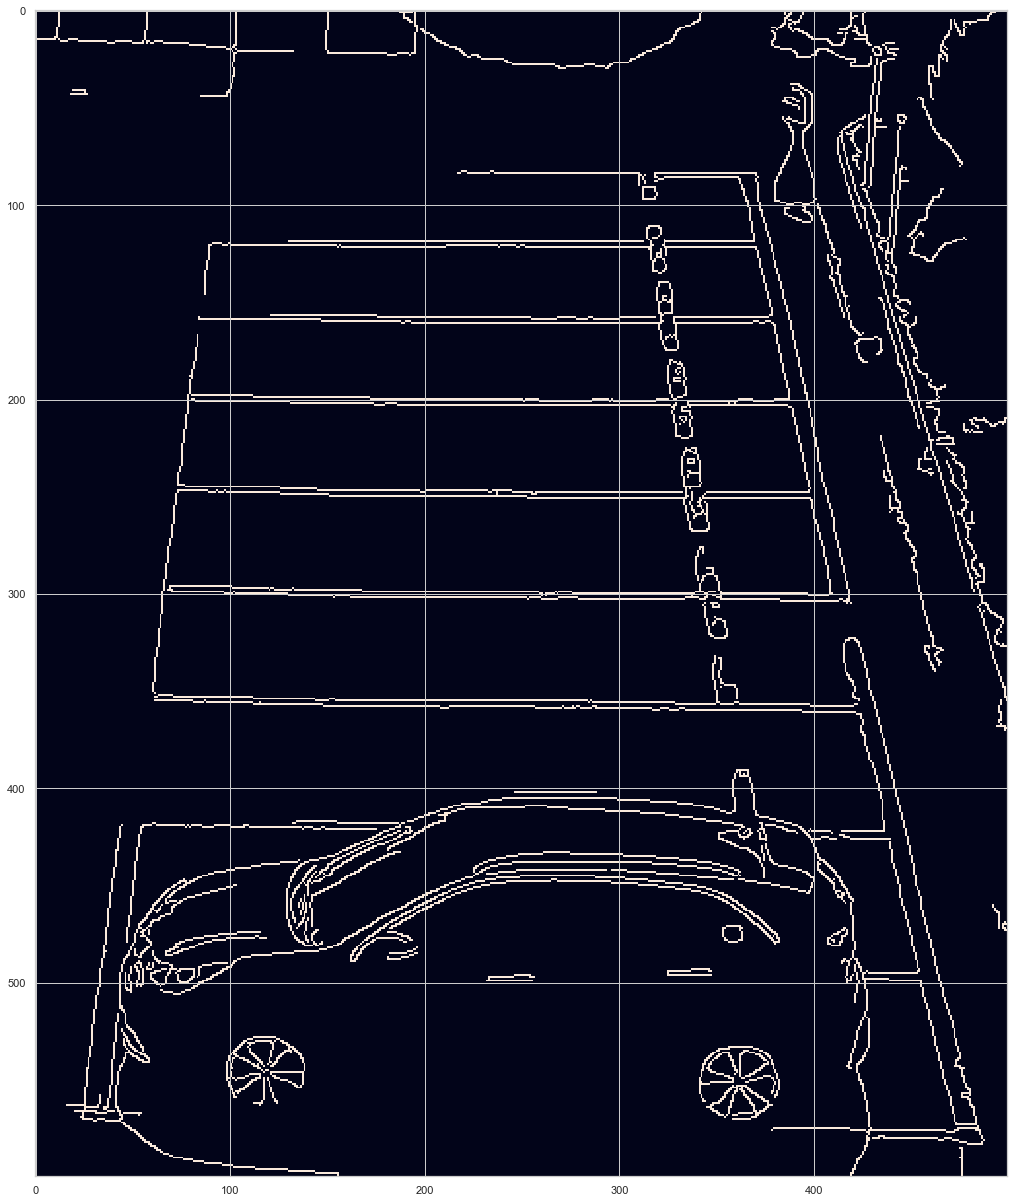

In [86]:
edged = cv2.Canny(blur, 100, 250,apertureSize = 3)
plt.figure(figsize=[20,20])
plt.imshow(edged)

# 모델에 학교 주차장 사진 넣어서 test해보기

## 주차장 사진 추출 

In [ ]:
img = cv2.imread('parking5.jpg',cv2.IMREAD_COLOR)
#img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
dst = img.copy() 
dst = img[1200:1800, 1500:2000]

#cv2.imshow("img", img)
#cv2.imshow("dst", dst)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

#plt.figure(figsize=[20,20])
plt.imshow(dst[:,:,::-1])
cv2.imwrite("target1.jpg", dst)

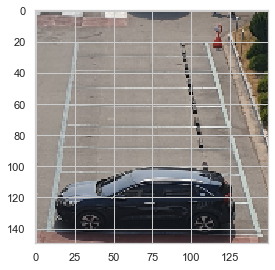

In [107]:
import numpy as np
img2 = cv2.imread("target1.jpg",cv2.IMREAD_COLOR)
img2 = cv2.resize(img2, (150,150))
plt.imshow(img2[:,:,::-1])

In [109]:
img2 = np.reshape(img2, (-1,150,150,3))
pred=model.predict([img2])
pred_digits=np.argmax(pred,axis=1)

In [110]:
print(pred_digits)

[1]


## - 최종 output이 0이 나오므로 비어있다고 잘 예측함

# full인 사진 넣어보기 - full이면 0이 최종 output

In [113]:
import numpy as np
img_full = cv2.imread('C:\Python\Source\input\data\data\Full\img_127100058.jpg',cv2.IMREAD_COLOR)
img_full = cv2.resize(img_full, (150,150))
img_full = np.reshape(img_full, (-1,150,150,3))

In [114]:
img_full.shape

(1, 150, 150, 3)

In [115]:
pred=model.predict([img_full])
pred_digits=np.argmax(pred,axis=1)

In [116]:
print(pred_digits)

[0]
